In [23]:
# google_play_scraperのインストール
!pip install google_play_scraper

In [24]:
# ライブラリの読み込み
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

In [25]:
# google_play_scraperでレビュー取得
from google_play_scraper import Sort, reviews_all

# 「Uber - Request a ride - Google Play」からレビューを取得する
jp_reviews = reviews_all(
    'com.ubercab.eats',
    sleep_milliseconds=0,  # defaults to 0
    lang='ja',  # defaults to 'en'
    country='jp',  # defaults to 'us'
    sort=Sort.NEWEST,  # defaults to Sort.MOST_RELEVANT
)

In [26]:
# 取得したレビューをデータフレームに格納
df_bush = pd.DataFrame(np.array(jp_reviews), columns=['review'])
df_bush = df_bush.join(pd.DataFrame(df_bush.pop('review').tolist()))

## 01.月別スコアの集計


### 運用開始日から現在までのスコア推移を棒グラフで表示

In [42]:
df = df_bush[['at', 'score', 'content']]
df.to_csv('Uber_Eats.csv', index=False, escapechar='\\')

In [36]:
df['score'].value_counts()  # ユニーク値（score）のカウント

5    6926
1    6703
4    3375
3    2013
2    1331
Name: score, dtype: int64

In [37]:
# 月別でスコア数を表示
df_score = df[['at', 'score']]

# crosstableでscoreを横軸に変換
df_score = pd.crosstab(df['at'], df['score'], dropna=False)

# resampleで月毎に
df_score = df_score.resample('M').sum()

# 月別スコア データフレームを作成
df_score

score,1,2,3,4,5
at,,,,,
2016-09-30,0,0,1,0,1
2016-10-31,4,1,0,1,4
2016-11-30,0,0,0,0,4
2016-12-31,1,0,0,0,4
2017-01-31,1,1,0,0,2
...,...,...,...,...,...
2023-07-31,92,28,26,51,76
2023-08-31,103,25,32,53,94
2023-09-30,75,20,16,39,95


<Axes: xlabel='at'>

<Figure size 640x480 with 0 Axes>

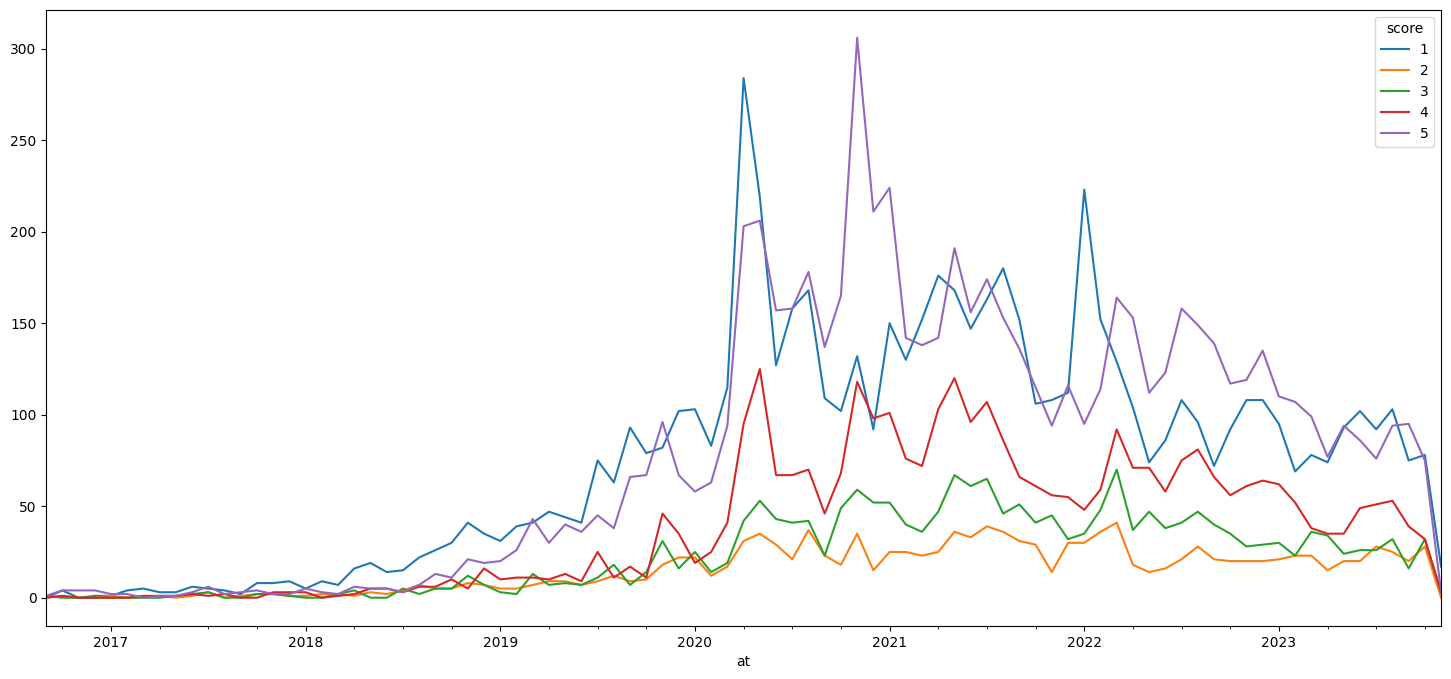

In [39]:
# plotで折れ線グラフを表示
plt.figure()
df_score.plot(figsize=(18,8))

リリース当初
- 高評価が目立つものの、低評価（1~2）も無視できない様子

現在（11月）
- 低評価の方が目立つようになる

### 100%積み上げ棒グラフで年別スコアを集計

In [38]:
# 100%積み上げグラフで表示
# 年別で集計
df_score_month = df_score.resample('Y').sum()
df_score_month

score,1,2,3,4,5
at,,,,,
2016-12-31,5,1,1,1,13
2017-12-31,58,12,11,14,28
2018-12-31,239,47,42,62,100
2019-12-31,737,122,137,209,574
2020-12-31,1692,295,462,839,1936
2021-12-31,1744,346,583,999,1781
2022-12-31,1352,285,495,802,1578
2023-12-31,876,223,282,449,916


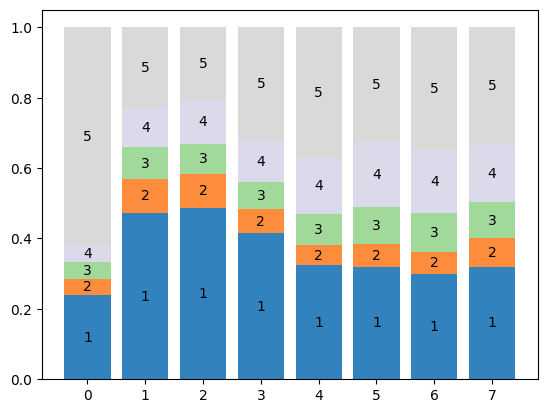

In [40]:
# 100%積み上げグラフ
# 正規化する
df_score_month2 = df_score_month.div(df_score_month.sum(axis=1), axis=0)

n_rows, n_cols = df_score_month2.shape
positions = np.arange(n_rows)
offsets = np.zeros(n_rows, dtype=df_score_month2.values.dtype)
colors = plt.get_cmap("tab20c")(np.linspace(0, 1, n_cols))

fig, ax = plt.subplots()
ax.set_xticks(positions)

for i in range(len(df_score_month2.columns)):
    # 棒グラフを描画する。
    bar = ax.bar(positions, df_score_month2.iloc[:, i], bottom=offsets, color=colors[i])
    offsets += df_score_month2.iloc[:, i]

    # 棒グラフのラベルを描画する。
    for rect in bar:
        cx = rect.get_x() + rect.get_width() / 2
        cy = rect.get_y() + rect.get_height() / 2
        ax.text(cx, cy, df_score_month2.columns[i], color="k", ha="center", va="center")


まだ折れ線グラフ・棒グラフの可視化から、リリースしてから３ヶ月足らずだが、評価が減少傾向にあることがわかった。

### 直近1カ月間のスコア推移とレビューの表示

In [30]:
# 2023年度のスコア推移とレビューの表示
date_start = "2023-01-01"

df_score_ex = df_score[date_start:]
df_score_ex

score,1,2,3,4,5
at,,,,,
2023-01-31,95,21,30,62,110
2023-02-28,69,23,23,52,107
2023-03-31,78,23,36,38,99
2023-04-30,74,15,34,35,77
2023-05-31,93,20,24,35,94
2023-06-30,102,20,26,49,86
2023-07-31,92,28,26,51,76
2023-08-31,103,25,32,53,94
2023-09-30,75,20,16,39,95


<Axes: xlabel='at'>

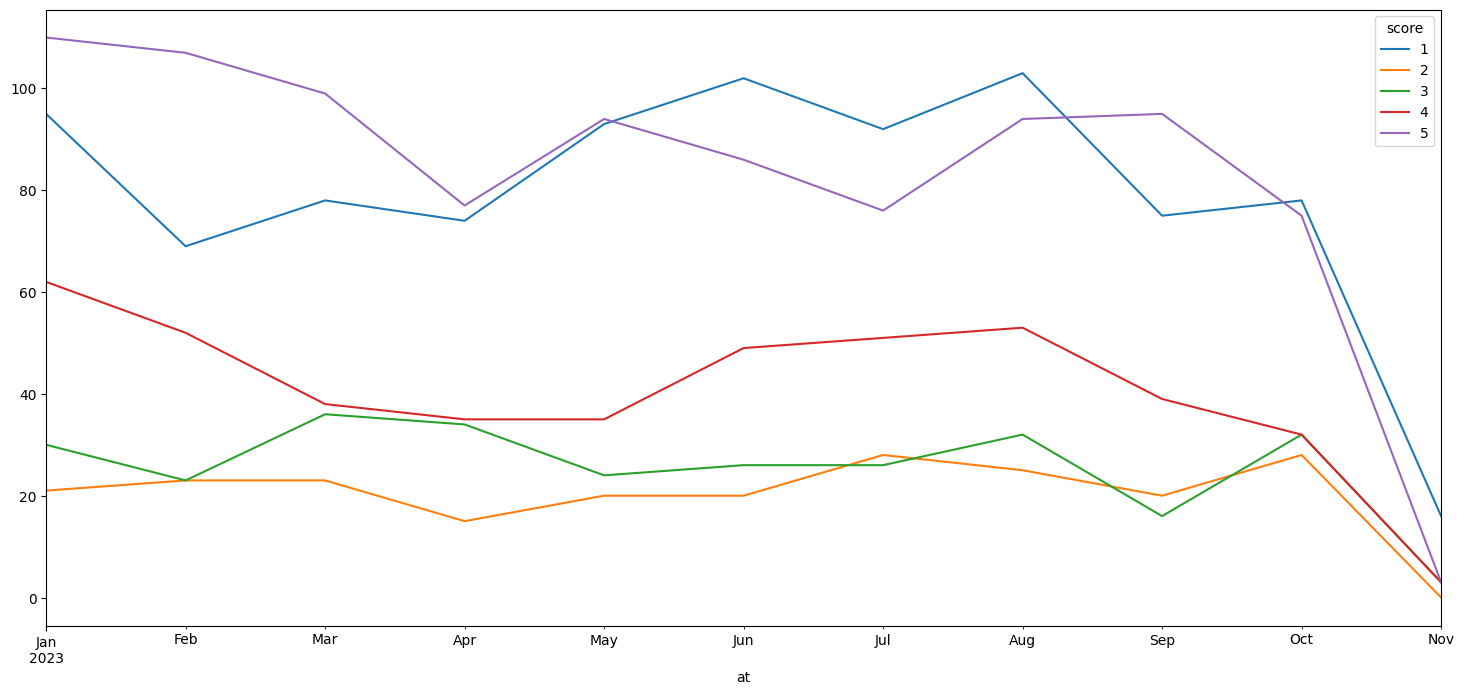

In [31]:
# グラフの表示
df_score_ex.plot(figsize=(18,8))

## 02.テキストマイニング（形態素解析

In [13]:
# 直近1カ月のレビューをデータフレーム化
df1 = df_bush[['at','content']]
df1 = df[(df['at'] > dt.datetime(2023,10,1)) & (df['at'] < dt.datetime(2023,10,31))]

テキストのみ抽出

In [14]:
df1 = df1[['content']]
df1 = df1.rename(columns={'content': 'text'})

MeCabで形態素解析を行う

In [15]:
#インストール
!pip install mecab-python3

#辞書インストール
!pip install unidic-lite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658816 sha256=2c285e7c55640db388cd386a3befb85763e845c33e8a0d124e145595e05ae0fa
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


In [16]:
# MeCabで形態素解析を行う
import MeCab

def mecab_text(text):

    #MeCabのインスタンスを作成（辞書はmecab-ipadic-neologdを使用）
    mecab = MeCab.Tagger('-Owakati')

    #形態素解析
    node = mecab.parseToNode(text)

    #形態素解析した結果を格納するリスト
    wordlist = []

    while node:
        #名詞のみリストに格納する
        if node.feature.split(',')[0] == '名詞':
            wordlist.append(node.surface)
        #形容詞を取得、elifで追加する
        elif node.feature.split(',')[0] == '形容詞':
            wordlist.append(node.surface)
        #動詞を取得、elifで追加する
        #elif node.feature.split(',')[0] == '動詞':
        #    wordlist.append(node.surface)
        node = node.next
    return wordlist

# 形態素結果をリスト化し、データフレームdf1に結果を列追加する
df1['words'] = df1['text'].apply(mecab_text)

# 表示
df1


,text,words
33,雨の日とかに助かっています。また体調が悪い時に頼んでいます。配達員さんありがとうございます。,"[雨, 日, 体調, 悪い, 時, 配達]"
34,キャンペーンか何かで安くなるので頼むと、1時間以上経ってからキャンセルの通知が来ました。それ...,"[キャンペーン, 安く, 1, 時間, 以上, キャンセル, 通知, 内容, ボタン, 存在..."
35,とにかく適当な配達員がひどい 出前館と質が全然違う,"[適当, 配達, ひどい, 出前, 質]"
36,削除された商品の返金が、されない‼️現在で二件の商品代金‼️,"[削除, 商品, 返金, 現在, 二, 件, 商品, 代金]"
37,いいアプリです,"[いい, アプリ]"
...,...,...
265,クーポンあるからうれしいけれどもう無くなるから無理めかな。コンビニスィーツやすいし、かい安め...,"[クーポン, うれしい, 無理, コンビニ, スィーツ, かい, 送料, タダ, ガード, ..."
266,ドライバーさんがめっちゃ気さくで、何でも教えてくださり、今後の参考にもなりました。ありがとう...,"[ドライバー, 今後, 参考]"
267,ウーバーで注文すると、全商品が店舗価格の約２倍になり更に量も少ない（実物は写真と全く違う詐欺...,"[バー, 注文, 商品, 店舗, 価格, ２, 倍, 量, 少ない, 実物, 写真, 詐欺,..."
268,カートに載せたものが保証されない。注文を始めているのに確定の段階で受付終了になったりして実に...,"[カート, もの, 保証, 注文, 確定, 段階, 受付, 終了, 実, 無能, 設計, アプリ]"


In [17]:
pip install nlplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.9/967.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.6 MB/s eta 0:00:00


In [18]:
# nlplotで直近1カ月のレビューを可視化・分析
# 頻出単語
import nlplot

npt = nlplot.NLPlot(df1, target_col='words')

# top_nで頻出上位単語, min_freqで頻出下位単語を指定
stopwords = npt.get_stopword(top_n=0, min_freq=0)

npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    stopwords=stopwords,
)


100%|██████████| 237/237 [00:00<00:00, 71679.41it/s]


In [19]:
npt.word_distribution(
    title='number of words distribution',
    xaxis_label='count',
)

In [20]:
# 単語数の分布
npt.treemap(
    title='Tree of Most Common Words',
    ngram=1,
    top_n=30,
    stopwords=stopwords,
)

100%|██████████| 237/237 [00:00<00:00, 53320.28it/s]


In [21]:
# ワードクラウド
npt.wordcloud(
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    stopwords=stopwords,
)